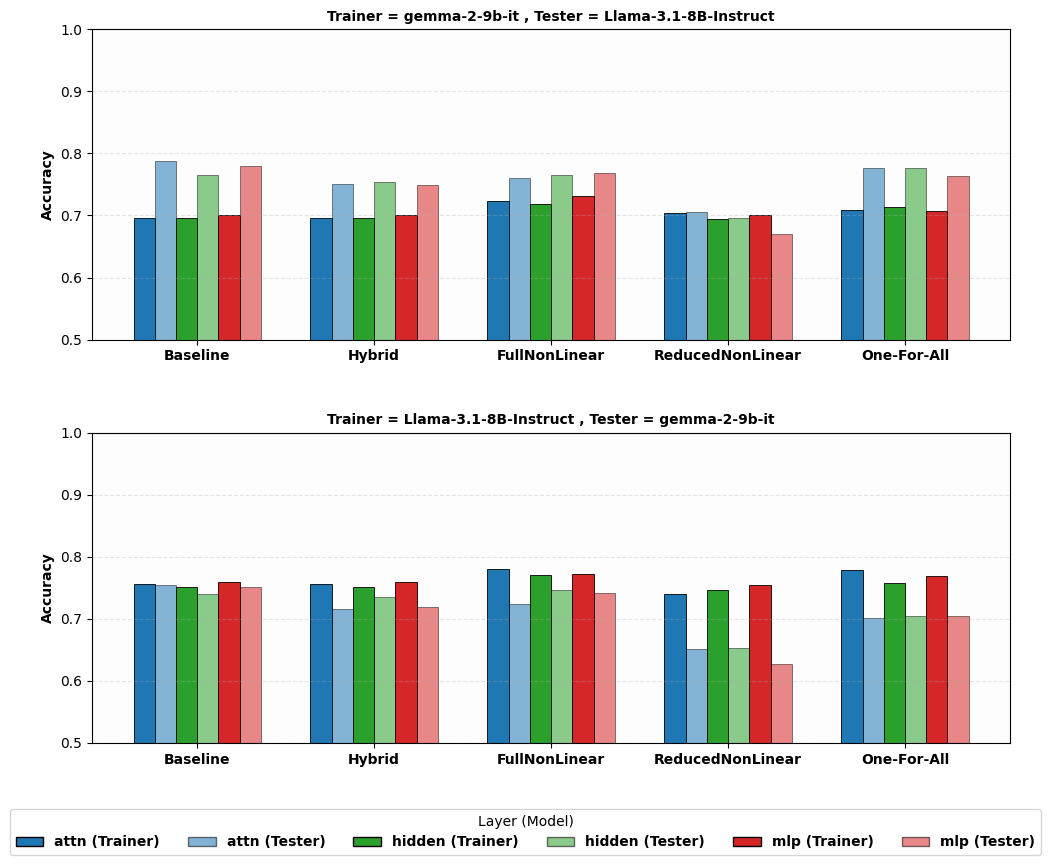

In [10]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# -----------------------------
# Configuration (change these to plot other datasets)
# -----------------------------
config = {
    "dataset": "LLama_Gemma_HE",
    "trainer_model": "gemma-2-9b-it",
    "tester_model": "Llama-3.1-8B-Instruct",
    "include_reverse": True,
}

dataset = config["dataset"]
trainer_model_name = config["trainer_model"]
tester_model_name = config["tester_model"]
base_dir = Path.cwd()

approaches = [
    "Baseline",
    "Hybrid",
    "FullNonLinear",
    "ReducedNonLinear",
    "One-For-All",
]
layers = ["attn", "hidden", "mlp"]

path_templates = {
    "Baseline": "linearApproach/{dataset}/results_metrics/linear_probe_results.json",
    "Hybrid": "HybridApproach/{dataset}/results_metrics/hybrid_adapter_logreg_results.json",
    "FullNonLinear": "nonLinearApproach/approach1FullDIM/{dataset}/results_metrics/approach1_mlp_prober_results.json",
    "ReducedNonLinear": "nonLinearApproach/approach2Projected/{dataset}/results_metrics/approach2_autoencoder_results.json",
    "One-For-All": "nonLinearApproach/approach3OneForAll/{dataset}/results_metrics/approach3_frozen_head_results.json",
}

paths = {
    approach: base_dir / template.format(dataset=dataset)
    for approach, template in path_templates.items()
}

scenario_pairs = [(trainer_model_name, tester_model_name)]
if config.get("include_reverse") and trainer_model_name != tester_model_name:
    scenario_pairs.append((tester_model_name, trainer_model_name))

scenario_data = {pair: {} for pair in scenario_pairs}

# -----------------------------
# Helpers
# -----------------------------
def normalize_metrics(result: dict) -> dict:
    if "metrics" in result:
        return result["metrics"]

    metrics = {}
    if "teacher" in result:
        metrics["teacher"] = result["teacher"]
    if "student_on_teacher" in result:
        metrics["student_on_teacher"] = result["student_on_teacher"]
    if "student_adapter" in result:
        metrics["student_adapter"] = result["student_adapter"]
    return metrics

for approach, path in paths.items():
    if not path.exists():
        print(f"Warning: file not found for {approach}: {path}")
        continue

    with open(path, "r", encoding="utf-8") as f:
        content = json.load(f)

    if approach == "One-For-All":
        for entry in content:
            teacher = entry.get("teacher_model", "")
            student = entry.get("student_model", "")
            pair_key = (teacher, student)
            if pair_key not in scenario_data:
                continue

            layer = entry.get("layer_type")
            if layer not in layers:
                continue

            metrics = entry.get("metrics", {})
            acc_t = metrics.get("teacher", {}).get("accuracy", 0)
            acc_s = metrics.get("student_adapter", {}).get("accuracy", 0)

            scenario_data[pair_key].setdefault(approach, {})[layer] = {
                "Trainer": acc_t,
                "Tester": acc_s,
            }
        continue

    for scenario_group in content:
        results = scenario_group.get("results", [])
        if not results:
            continue

        first_result = results[0]
        teacher = first_result.get("teacher_model") or first_result.get("teacher_name")
        student = first_result.get("student_model") or first_result.get("student_name")
        pair_key = (teacher, student)
        if pair_key not in scenario_data:
            continue

        for result in results:
            layer = result.get("layer_type") or result.get("type")
            if layer not in layers:
                continue

            metrics = normalize_metrics(result)
            trainer_metrics = metrics.get("teacher", {})
            tester_metrics = (
                metrics.get("student_on_teacher")
                or metrics.get("student_adapter")
                or {}
            )
            acc_t = trainer_metrics.get("accuracy", 0)
            acc_s = tester_metrics.get("accuracy", 0)

            scenario_data[pair_key].setdefault(approach, {})[layer] = {
                "Trainer": acc_t,
                "Tester": acc_s,
            }

# -----------------------------
# Plot parameters
# -----------------------------
x = np.arange(len(approaches))
bar_width = 0.12
colors = {"attn": "tab:blue", "hidden": "tab:green", "mlp": "tab:red"}
offsets = {
    ("attn", "Trainer"): -2.5 * bar_width,
    ("attn", "Tester"): -1.5 * bar_width,
    ("hidden", "Trainer"): -0.5 * bar_width,
    ("hidden", "Tester"): 0.5 * bar_width,
    ("mlp", "Trainer"): 1.5 * bar_width,
    ("mlp", "Tester"): 2.5 * bar_width,
}
bar_kwargs = {"edgecolor": "black", "linewidth": 0.6}
title_style = {"fontsize": 10, "fontweight": "bold"}
label_style = {"fontsize": 10, "fontweight": "bold"}
tick_style = {"fontsize": 10, "fontweight": "bold"}
legend_prop = {"size": 10, "weight": "bold"}

scenarios_to_plot = [pair for pair in scenario_pairs if scenario_data[pair]]
if not scenarios_to_plot:
    raise RuntimeError("Nessun scenario valido trovato per i modelli trainer/tester configurati.")

nrows = len(scenarios_to_plot)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=1,
    figsize=(10, 8.5),
    sharex=False,  # Cambiato a False per mostrare le etichette su entrambi i subplot
    sharey=True,
)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

for ax, scenario_key in zip(axes, scenarios_to_plot):
    teacher_name, student_name = scenario_key
    setup_data = scenario_data[scenario_key]
    ax.set_facecolor("#fdfdfd")
    ax.grid(axis="y", linestyle="--", alpha=0.3, linewidth=0.8)

    for layer in layers:
        for role in ["Trainer", "Tester"]:
            values = [
                setup_data.get(approach, {}).get(layer, {}).get(role, 0),
                for approach in approaches,
            ]
            ax.bar(
                x + offsets[(layer, role)],
                values,
                width=bar_width,
                color=colors[layer],
                alpha=1.0 if role == "Trainer" else 0.55,
                **bar_kwargs,
            )

    ax.set_title(f"Trainer = {teacher_name} , Tester = {student_name}", **title_style)
    ax.set_ylim(0.5, 1.0)
    ax.set_ylabel("Accuracy", **label_style)
    ax.set_xticks(x)
    ax.set_xticklabels(approaches, rotation=0, ha="center")
    for label in ax.get_xticklabels():
        label.set_fontsize(tick_style["fontsize"])
        label.set_fontweight(tick_style["fontweight"])
    # Rendere in grassetto i tick dell'asse Y
    for ylab in ax.get_yticklabels():
        ylab.set_fontsize(tick_style["fontsize"])
        ylab.set_fontweight(tick_style["fontweight"])

#axes[-1].set_xlabel("Approach", **label_style)

legend_handles = []
for layer in layers:
    legend_handles.append(
        Patch(
            facecolor=colors[layer],
            edgecolor="black",
            alpha=1.0,
            label=f"{layer} (Trainer)",
        )
    )
    legend_handles.append(
        Patch(
            facecolor=colors[layer],
            edgecolor="black",
            alpha=0.55,
            label=f"{layer} (Tester)",
        )
    )

# Legenda posizionata sotto l'intera figura
fig.legend(
    handles=legend_handles,
    title="Layer (Model)",
    loc="upper left",
    bbox_to_anchor=(0.01, 0.98),
    ncol=1,
    frameon=True,
    prop=legend_prop,
)

fig.tight_layout()
fig.subplots_adjust(bottom=0.12, hspace=0.3)  # Più spazio in basso per la legenda
plt.savefig(f"accuracy_bars_approach_{dataset}.pdf", bbox_inches='tight')
plt.show()


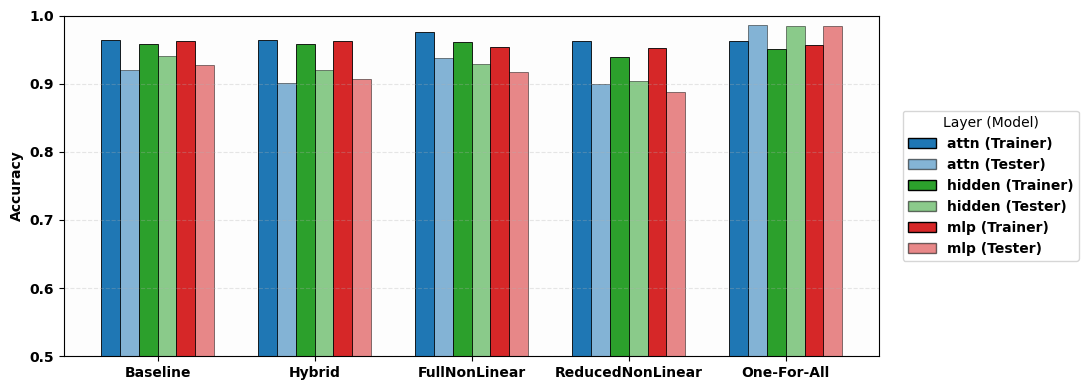

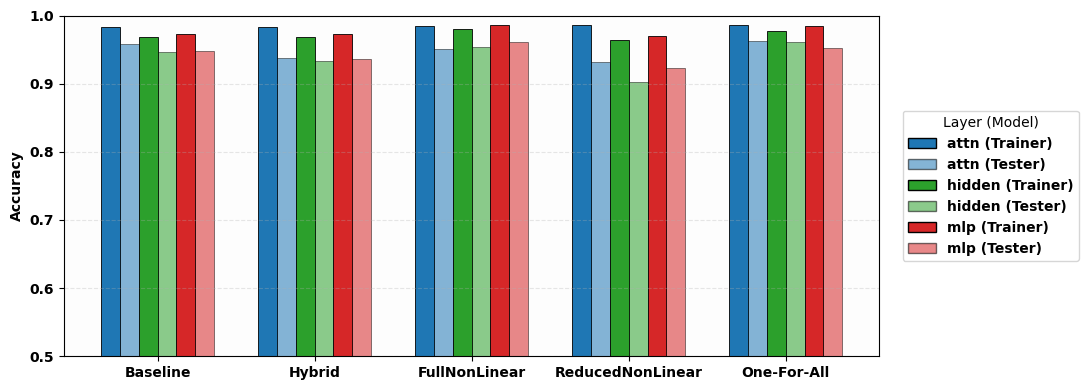

In [ ]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# -----------------------------
# Configuration (change these to plot other datasets)
# -----------------------------
config = {
    "dataset": "LLama_Gemma_BBF",
    "trainer_model": "gemma-2-9b-it",
    "tester_model": "Llama-3.1-8B-Instruct",
    "include_reverse": True,
}

dataset = config["dataset"]
trainer_model_name = config["trainer_model"]
tester_model_name = config["tester_model"]
base_dir = Path.cwd()

approaches = [
    "Baseline",
    "AdapterMLP",
    "FullNonLinear",
    "ReducedNonLinear",
    "One-For-All",
]
layers = ["attn", "hidden", "mlp"]

path_templates = {
    "Baseline": "linearApproach/{dataset}/results_metrics/linear_probe_results.json",
    "AdapterMLP": "HybridApproach/{dataset}/results_metrics/hybrid_adapter_logreg_results.json",
    "FullNonLinear": "nonLinearApproach/approach1FullDIM/{dataset}/results_metrics/approach1_mlp_prober_results.json",
    "ReducedNonLinear": "nonLinearApproach/approach2Projected/{dataset}/results_metrics/approach2_autoencoder_results.json",
    "One-For-All": "nonLinearApproach/approach3OneForAll/{dataset}/results_metrics/approach3_frozen_head_results.json",
}

paths = {
    approach: base_dir / template.format(dataset=dataset)
    for approach, template in path_templates.items()
}

scenario_pairs = [(trainer_model_name, tester_model_name)]
if config.get("include_reverse") and trainer_model_name != tester_model_name:
    scenario_pairs.append((tester_model_name, trainer_model_name))

scenario_data = {pair: {} for pair in scenario_pairs}

# -----------------------------
# Helpers
# -----------------------------
def normalize_metrics(result: dict) -> dict:
    if "metrics" in result:
        return result["metrics"]

    metrics = {}
    if "teacher" in result:
        metrics["teacher"] = result["teacher"]
    if "student_on_teacher" in result:
        metrics["student_on_teacher"] = result["student_on_teacher"]
    if "student_adapter" in result:
        metrics["student_adapter"] = result["student_adapter"]
    return metrics

for approach, path in paths.items():
    if not path.exists():
        print(f"Warning: file not found for {approach}: {path}")
        continue

    with open(path, "r", encoding="utf-8") as f:
        content = json.load(f)

    if approach == "One-For-All":
        for entry in content:
            teacher = entry.get("teacher_model", "")
            student = entry.get("student_model", "")
            pair_key = (teacher, student)
            if pair_key not in scenario_data:
                continue

            layer = entry.get("layer_type")
            if layer not in layers:
                continue

            metrics = entry.get("metrics", {})
            acc_t = metrics.get("teacher", {}).get("accuracy", 0)
            acc_s = metrics.get("student_adapter", {}).get("accuracy", 0)

            scenario_data[pair_key].setdefault(approach, {})[layer] = {
                "Trainer": acc_t,
                "Tester": acc_s,
            }
        continue

    for scenario_group in content:
        results = scenario_group.get("results", [])
        if not results:
            continue

        first_result = results[0]
        teacher = first_result.get("teacher_model") or first_result.get("teacher_name")
        student = first_result.get("student_model") or first_result.get("student_name")
        pair_key = (teacher, student)
        if pair_key not in scenario_data:
            continue

        for result in results:
            layer = result.get("layer_type") or result.get("type")
            if layer not in layers:
                continue

            metrics = normalize_metrics(result)
            trainer_metrics = metrics.get("teacher", {})
            tester_metrics = (
                metrics.get("student_on_teacher")
                or metrics.get("student_adapter")
                or {}
            )
            acc_t = trainer_metrics.get("accuracy", 0)
            acc_s = tester_metrics.get("accuracy", 0)

            scenario_data[pair_key].setdefault(approach, {})[layer] = {
                "Trainer": acc_t,
                "Tester": acc_s,
            }

# -----------------------------
# Plot parameters
# -----------------------------
x = np.arange(len(approaches))
bar_width = 0.12
colors = {"attn": "tab:blue", "hidden": "tab:green", "mlp": "tab:red"}
offsets = {
    ("attn", "Trainer"): -2.5 * bar_width,
    ("attn", "Tester"): -1.5 * bar_width,
    ("hidden", "Trainer"): -0.5 * bar_width,
    ("hidden", "Tester"): 0.5 * bar_width,
    ("mlp", "Trainer"): 1.5 * bar_width,
    ("mlp", "Tester"): 2.5 * bar_width,
}
bar_kwargs = {"edgecolor": "black", "linewidth": 0.6}
title_style = {"fontsize": 10, "fontweight": "bold"}
label_style = {"fontsize": 10, "fontweight": "bold"}
tick_style = {"fontsize": 10, "fontweight": "bold"}
legend_prop = {"size": 10, "weight": "bold"}

scenarios_to_plot = [pair for pair in scenario_pairs if scenario_data[pair]]
if not scenarios_to_plot:
    raise RuntimeError("Nessun scenario valido trovato per i modelli trainer/tester configurati.")

# Salva figure separate per ogni scenario
for scenario_key in scenarios_to_plot:
    teacher_name, student_name = scenario_key
    setup_data = scenario_data[scenario_key]

    fig, ax = plt.subplots(figsize=(11, 4))
    ax.set_facecolor("#fdfdfd")
    ax.grid(axis="y", linestyle="--", alpha=0.3, linewidth=0.8)

    for layer in layers:
        for role in ["Trainer", "Tester"]:
            values = [
                setup_data.get(approach, {}).get(layer, {}).get(role, 0)
                for approach in approaches
            ]
            ax.bar(
                x + offsets[(layer, role)],
                values,
                width=bar_width,
                color=colors[layer],
                alpha=1.0 if role == "Trainer" else 0.55,
                **bar_kwargs,
            )

    ax.set_ylim(0.5, 1.0)
    ax.set_ylabel("Accuracy", **label_style)
    ax.set_xticks(x)
    ax.set_xticklabels(approaches, rotation=0, ha="center")
    
    # Make x-axis labels bold
    for label in ax.get_xticklabels():
        label.set_fontsize(tick_style["fontsize"])
        label.set_fontweight(tick_style["fontweight"])
    
    # Make y-axis tick labels bold
    for label in ax.get_yticklabels():
        label.set_fontweight("bold")

    legend_handles = []
    for layer in layers:
        legend_handles.append(
            Patch(
                facecolor=colors[layer],
                edgecolor="black",
                alpha=1.0,
                label=f"{layer} (Trainer)",
            )
        )
        legend_handles.append(
            Patch(
                facecolor=colors[layer],
                edgecolor="black",
                alpha=0.55,
                label=f"{layer} (Tester)",
            )
        )

    # Place legend vertically on the right side
    ax.legend(
        handles=legend_handles,
        title="Layer (Model)",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=True,
        prop=legend_prop,
    )

    fig.tight_layout()
    filename = f"accuracy_bars_approach_{dataset}_{teacher_name.replace('/', '_')}_{student_name.replace('/', '_')}.pdf"
    plt.savefig(filename, bbox_inches='tight')
    plt.show()